# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.269081,False,0.394192
1,0.841994,True,8.006270
2,1.336668,True,7.690033
3,-0.348362,False,0.580294
4,-1.278585,False,-0.168227
...,...,...,...
995,0.980275,True,5.476466
996,-0.451453,False,0.640976
997,-0.735478,False,0.466942
998,-1.182216,False,-1.120052


<AxesSubplot: xlabel='v0'>

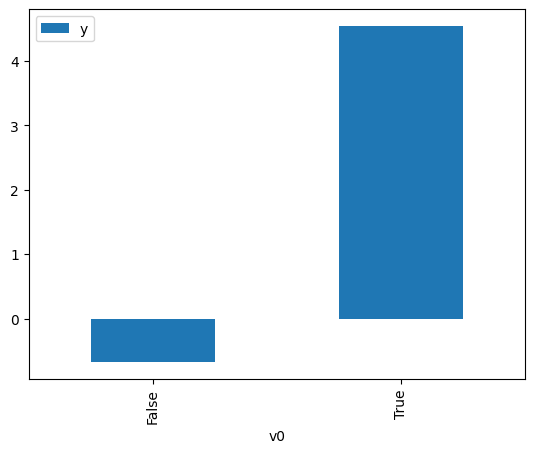

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

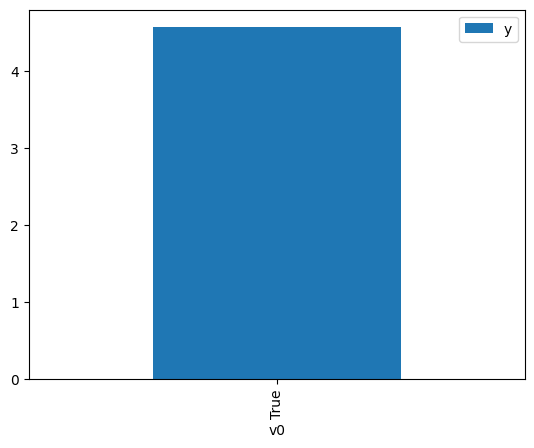

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.261125,False,-0.208418,0.620461,1.611705
1,-0.461002,False,-2.050497,0.725465,1.378426
2,-2.244137,False,-3.867934,0.994811,1.005216
3,-0.838721,False,-1.021192,0.867526,1.152704
4,-0.853096,False,-1.785286,0.871445,1.147520
...,...,...,...,...,...
995,-0.099527,False,0.634903,0.525788,1.901906
996,-0.372711,False,-1.155677,0.681268,1.467851
997,0.048756,False,-0.462660,0.437079,2.287914
998,-0.277210,False,0.563189,0.629519,1.588515


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.059656,True,5.066586,0.569353,1.756379
1,-1.647519,True,2.757396,0.021405,46.718194
2,1.368670,True,5.994871,0.968455,1.032572
3,-1.411787,True,1.293661,0.037108,26.948688
4,0.558353,True,4.959528,0.814179,1.228231
...,...,...,...,...,...
995,0.191881,True,7.020342,0.644947,1.550515
996,0.322923,True,6.596749,0.713357,1.401822
997,0.059656,True,5.066586,0.569353,1.756379
998,-0.923333,True,5.411143,0.110805,9.024869


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.922
Model:                            OLS   Adj. R-squared (uncentered):              0.922
Method:                 Least Squares   F-statistic:                              5897.
Date:                Fri, 16 Dec 2022   Prob (F-statistic):                        0.00
Time:                        01:12:01   Log-Likelihood:                         -1401.7
No. Observations:                1000   AIC:                                      2807.
Df Residuals:                     998   BIC:                                      2817.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.1173      0.029     38.787      0.000       1.061       1.174
x2             4.9541      0.053     93.163      0.000       4.850       5.058
==============================================================================
Omnibus:                        1.724   Durbin-Watson:                   2.129
Prob(Omnibus):                  0.422   Jarque-Bera (JB):                1.750
Skew:                          -0.066   Prob(JB):                        0.417
Kurtosis:                       2.843   Cond. No.                         1.90
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""